## ARGO Labs
### Sierra SWE Prediction Model Testing

Comments:

Two Models are Tested and Calibrated: 

1) XGBoost (XGB):
    
    Uncalibrated: Test RMSE = 2.454164972965364, Training RMSE = 1.293246518352459
    
    Calibrated: Test RMSE =  2.071810883149162, Training RMSE = 0.5296882625584641

2) Long-Short Term Memory (LSTM) RNN model
    
    Uncalibrated: Test RMSE = 0.942, Train RMSE - 0.939

    Calibrated:

In [423]:
swe['vol'].min()

0.00037199

In [363]:
#processing libraries:

import pandas as pd
import numpy as np
import geopandas as gpd
import os
from urllib.request import urlretrieve
import urllib.request as urllib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

#for XGB:

import xgboost as xgb

#For LSTM:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.datasets import mnist
from keras.layers import LSTM

#testing:

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

#visualization

import matplotlib.pyplot as plt
import seaborn as snb

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Baseline Data Pre-processing

In [364]:
def read_swe(url):
    '''function to read in and format the raw swe data (y data)'''
    
    swe_vol = pd.read_csv(url,header=None,names=['date','area','vol'])
    swe_vol['date'] = pd.to_datetime(swe_vol['date'])
    swe_vol.set_index('date',inplace=True)
    swe_vol.drop(columns=['area'],axis=1,inplace=True)
    
    return pd.DataFrame(swe_vol)

In [365]:
#read in y data
url = 'https://s3-us-west-2.amazonaws.com/cawater-public/swe/pred_SWE.txt'
swe_vol = read_swe(url)

In [368]:
def read_file(file_path):
    '''Function to read in daily x data'''
    if os.path.exists(os.getcwd()+'/'+file_path) == True:
        station = pd.read_csv(file_path)
    else:
        !unzip alldata.zip
        station = pd.read_csv(file_path)

    station['date'] = pd.to_datetime(station['date'])
    station = station.sort_values(by='date')
    station.set_index('date',inplace=True) #put date in the index
    station = station[station.index > '1984-09-29'] #removes days where there is no y-data
    station.replace('---','0',inplace=True)
    try:
        station.drop(columns=['Unnamed: 0'],axis=1,inplace=True) #drop non-station columns
    except:
        pass
    
    return station

In [369]:
#read in x data
file = 'fulldataset.csv'
station = read_file(file)

In [370]:
station.head()

,ADM,AGP,ALP,BCB,BCH,BFL,BGP,BIM,BKL,BLA,...,TUN,UBC,UTY,VLC,VRG,VVL,WC3,WHW,WTM,WWC
date,,,,,,,,,,,,,,,,,,,,,
1984-09-30,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.042672,...,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,-0.012192,0.0,-0.012192,-0.012192,-0.012192
1984-10-01,0.005608,0.005608,0.027940,0.005608,0.005608,0.005608,0.005608,0.005608,0.005608,0.005608,...,0.005608,0.005608,0.005608,0.005608,0.005608,0.066040,0.0,0.005608,0.005608,0.000000
1984-10-02,0.027940,0.002946,0.022860,0.002116,0.001463,0.002946,0.002885,0.002198,0.002776,-0.042672,...,0.002338,0.002269,0.002790,0.002879,0.002838,0.066040,0.0,0.002934,0.002499,0.000000
1984-10-03,0.022860,0.001665,0.015240,0.001267,0.000900,0.001665,0.001658,0.001382,0.001972,-0.042672,...,0.001420,0.001372,0.001637,0.001657,0.001651,0.066040,0.0,0.001665,0.001559,0.000000
1984-10-04,0.015240,0.001773,0.012700,0.001635,0.001377,0.001773,0.001773,0.001734,0.000000,-0.039624,...,0.001737,0.001718,0.001772,0.001773,0.001773,0.066040,0.0,0.001773,0.001772,0.000000


In [371]:
#join the data sets
swe = pd.merge(left=swe_vol,right=station,left_index=True,right_index=True)
swe.shape

(12501, 137)

In [372]:
#for now, dropping columns where we only have NaNs - these are the weather stations that have no daily data
swe.dropna(axis=1, how='all',inplace=True)

#### Process for replacing NaNs

## NOTE: This is old code to fill in NaN values, Vaidehi's interpolation calculations are being used instead

In [252]:
'''
def replace_nans(df):
    #function to fill the row NaNs for the individual weather stations
    
    #put volume in the index so it doesn't affect the averages:
    df.reset_index(inplace=True) 
    df.set_index(['date','vol'],inplace=True)
    
    #convert station columns to numeric values:
    cols = df.columns
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    
    ###FILL FUNCTION:
    df = df.apply(lambda row: row.fillna(row.mean()), axis=1)
    
    #reset index to prep for modeling:
    df.reset_index(inplace=True)
    df.set_index('date',inplace=True)
    
    return df'''

In [253]:
#replace nan's with row means
##swe = replace_nans(swe)

## OLD CODE ENDS

In [373]:
#check row parity
swe.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12501 entries, 1984-09-30 to 2018-12-30
Data columns (total 137 columns):
vol    12352 non-null float64
ADM    12501 non-null float64
AGP    12501 non-null float64
ALP    12501 non-null float64
BCB    12501 non-null float64
BCH    12501 non-null float64
BFL    12501 non-null float64
BGP    12501 non-null float64
BIM    12501 non-null float64
BKL    12501 non-null float64
BLA    12501 non-null float64
BLC    12501 non-null float64
BLD    12501 non-null float64
BLK    12501 non-null float64
BLS    12501 non-null float64
BMW    12501 non-null float64
BNK    12501 non-null float64
BSH    12501 non-null float64
BSK    12501 non-null float64
BTA    12501 non-null float64
CAP    12501 non-null float64
CBT    12501 non-null float64
CDP    12501 non-null float64
CHM    12501 non-null float64
CHP    12501 non-null float64
CRL    12501 non-null float64
CSL    12501 non-null float64
CSV    12501 non-null float64
CWD    12501 non-null float64
CWF

In [374]:
#export raw consolidated modeling data
swe.to_csv('swe_test.csv')

In [375]:
#split into three dataframes: train, test, and predict
train = swe.iloc[:round(len(swe) * 0.8)]
test = swe.iloc[round(len(swe) * 0.8):-125]
predict = swe.iloc[-125:] #predct is last 125 rows where there is no Y-data

In [378]:
#drop rows with Y NaN in train and test data...there are some missing volume days that need to be dropped for the models to work
train.dropna(subset=['vol'],inplace=True) 
test.dropna(subset=['vol'],inplace=True) 

/nfshome/cb4102/.conda/envs/deeplearn/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/nfshome/cb4102/.conda/envs/deeplearn/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [379]:
#quick check on lengths and % after drops (approx, no new denominator calculated)
print("training sample size: {}".format(len(train)), " | training %: {}".format((len(train) / len(swe))*100))
print("testing sample size: {}".format(len(test)), " | test %: {}".format((len(test) / len(swe))*100))
print("prediction sample size: {}".format(len(predict)), " | prediction %: {}".format((len(predict) / len(swe))*100))

training sample size: 9980  | training %: 79.83361331093512
testing sample size: 2372  | test %: 18.974482041436687
prediction sample size: 125  | prediction %: 0.9999200063994881


In [380]:
#split into X and Y for each of train, test, and predict
Y_train = train['vol']
X_train = train.iloc[:,1:]

Y_test = test['vol']
X_test = test.iloc[:,1:]

Y_predict = predict['vol']
X_predict = predict.iloc[:,1:]

# XGBoost Regression

In [381]:
#initialize baseline xgboost regression
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree=0.8, learning_rate=0.1,
                max_depth=10, n_estimators=20,seed=13)

In [382]:
#fit the model
xg_reg.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=13, silent=True,
       subsample=1)

In [383]:
#generate predictions
train_preds = xg_reg.predict(X_train)
test_preds = xg_reg.predict(X_test)
predict_preds = xg_reg.predict(X_predict) #for plooting

In [384]:
rmse = np.sqrt(mean_squared_error(Y_test, test_preds))
print("RMSE of the test set: {}".format(rmse))

RMSE of the test set: 2.454164972965364


In [385]:
rmse = np.sqrt(mean_squared_error(Y_train, train_preds))
print("RMSE of the train set: {}".format(rmse))

RMSE of the train set: 1.293246518352459


In [386]:
#join back to dates for graphing

train_graph = pd.merge(left=pd.DataFrame(train.index),right=pd.DataFrame(train_preds),how='left',
                       left_index=True,right_index=True)

test_graph = pd.merge(left=pd.DataFrame(test.index),right=pd.DataFrame(test_preds),how='left',
                       left_index=True,right_index=True)

pred_graph = pd.merge(left=pd.DataFrame(predict.index),right=pd.DataFrame(predict_preds),how='left',
                       left_index=True,right_index=True)

train_graph.set_index('date',inplace=True)
test_graph.set_index('date',inplace=True)
pred_graph.set_index('date',inplace=True)

In [387]:
#convert training data to data frames for graphing
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)

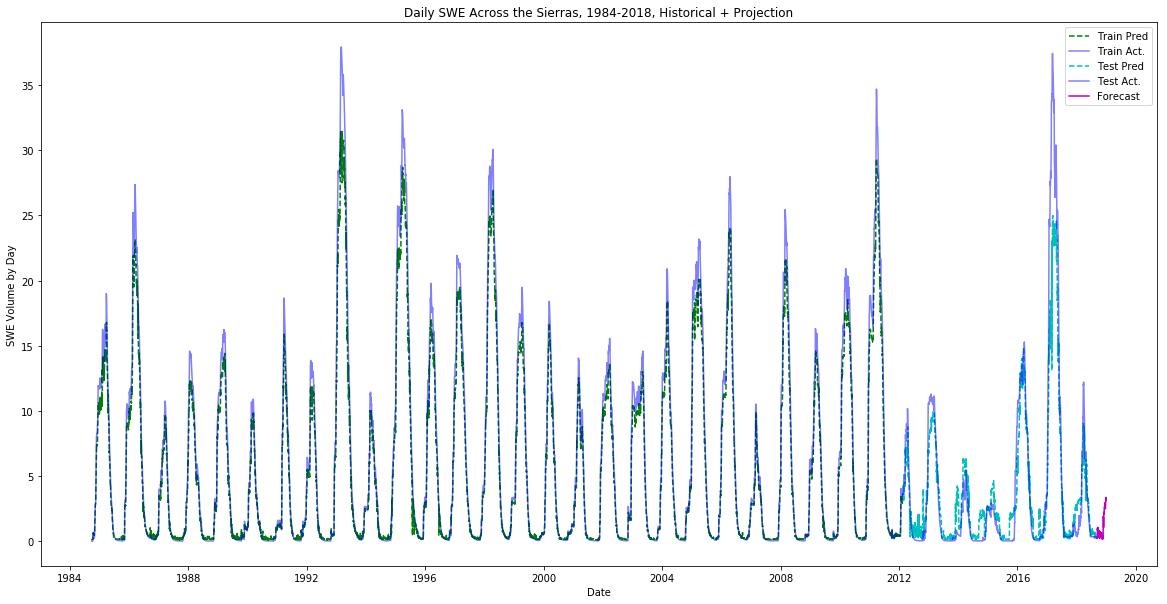

In [388]:
#quick plot to visualize data

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(train_graph[0],color='g',linestyle='--',label='Train Pred')
ax.plot(Y_train['vol'],color='b',alpha=0.5,label='Train Act.')

ax.plot(test_graph[0],color='c',linestyle='--',label='Test Pred')
ax.plot(Y_test['vol'],color='b',alpha=0.5,label='Test Act.')

ax.plot(pred_graph[0],color='m',label='Forecast')

ax.set_xlabel("Date")
ax.set_ylabel("SWE Volume by Day")
ax.set_title("Daily SWE Across the Sierras, 1984-2018, Historical + Projection")
plt.legend()

Text(0.5, 1.0, 'Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Train set)')

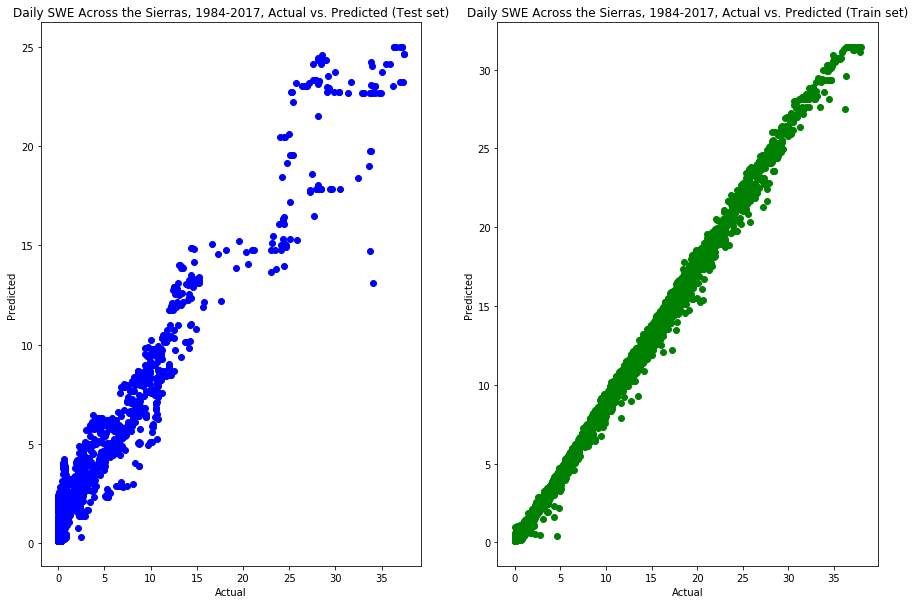

In [389]:
#scatter plot to show comparison of predicted vs actual on the training and test data sets

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)

ax.scatter(Y_test.values,test_preds,color='b')

ax1 = fig.add_subplot(122)

ax1.scatter(Y_train.values,train_preds,color='g')

ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title("Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Test set)")

ax1.set_xlabel("Actual")
ax1.set_ylabel("Predicted")
ax1.set_title("Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Train set)")

#### Hyper parameter optimization

In [390]:
xg_reg.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 10,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 20,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 13,
 'silent': True,
 'subsample': 1}

In [391]:
#set up cross-validation 
xgtrain = xgb.DMatrix(data=X_train.values,label=Y_train.values) #set up training data in xgboost format

xgb_param = xg_reg.get_xgb_params() #get underlying parameters from baseline regression

#generate cross validation results to estimate the correct number of estimators at a specified learning rate 
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=400, nfold=5,
            metrics='rmse', early_stopping_rounds=50)

Text(0.5, 1.0, '# of Estimators Hyper-parameter Analysis')

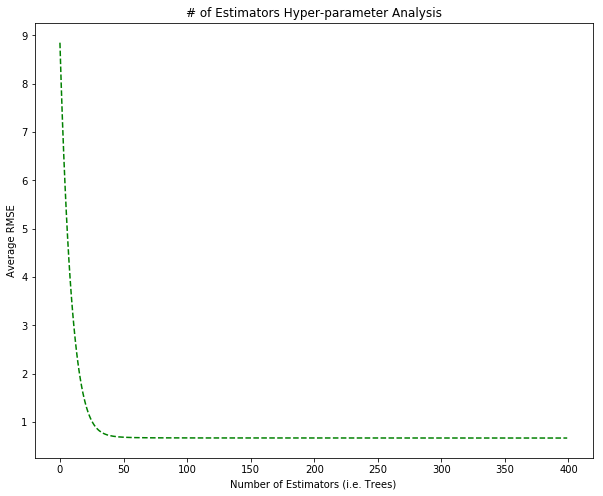

In [392]:
cvresult['test-rmse-mean']

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax.plot(cvresult['test-rmse-mean'],color='g',linestyle='--',label='Train Pred')

ax.set_xlabel("Number of Estimators (i.e. Trees)")
ax.set_ylabel("Average RMSE")
ax.set_title("# of Estimators Hyper-parameter Analysis")


#### Note: Setting n_estimators = 50 is optimal, no additional performance benefits for a larger number and runtime will increase

In [393]:
#set optimal n_estimators
xg_reg.set_params(n_estimators=50)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=13, silent=True,
       subsample=1)

### Tune max_depth and min_child_weight

These parameters impact overfitting and need to be tuned

In [394]:
#set tests parameters for XGBoost Model
param_test1 = {
 'max_depth':range(3,10),
 'min_child_weight':range(1,6)}

#initialize grid search cross validation
gsearch1 = GridSearchCV(estimator=xg_reg, param_grid=param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,Y_train) #fit data
gsearch1.best_params_, gsearch1.best_score_ #output results from best iteration

({'max_depth': 6, 'min_child_weight': 1}, -7.328430325671647)

In [395]:
#set optimal parameter based on tuning
xg_reg.set_params(max_depth=5)
xg_reg.set_params(min_child_weight=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=13, silent=True,
       subsample=1)

### Rerun model with tuned parameters

In [396]:
#fit the model
xg_reg.fit(X_train,Y_train)

#generate predictions
train_preds = xg_reg.predict(X_train)
test_preds = xg_reg.predict(X_test)
predict_preds = xg_reg.predict(X_predict) #for plooting

In [397]:
rmse = np.sqrt(mean_squared_error(Y_test, test_preds))
print("RMSE of the test set: {}".format(rmse))

rmse = np.sqrt(mean_squared_error(Y_train, train_preds))
print("RMSE of the train set: {}".format(rmse))

RMSE of the test set: 2.071810883149162
RMSE of the train set: 0.5296882625584641


In [398]:
#join back to dates for graphing

train_graph = pd.merge(left=pd.DataFrame(train.index),right=pd.DataFrame(train_preds),how='left',
                       left_index=True,right_index=True)

test_graph = pd.merge(left=pd.DataFrame(test.index),right=pd.DataFrame(test_preds),how='left',
                       left_index=True,right_index=True)

pred_graph = pd.merge(left=pd.DataFrame(predict.index),right=pd.DataFrame(predict_preds),how='left',
                       left_index=True,right_index=True)

train_graph.set_index('date',inplace=True)
test_graph.set_index('date',inplace=True)
pred_graph.set_index('date',inplace=True)

#convert training data to data frames for graphing
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)

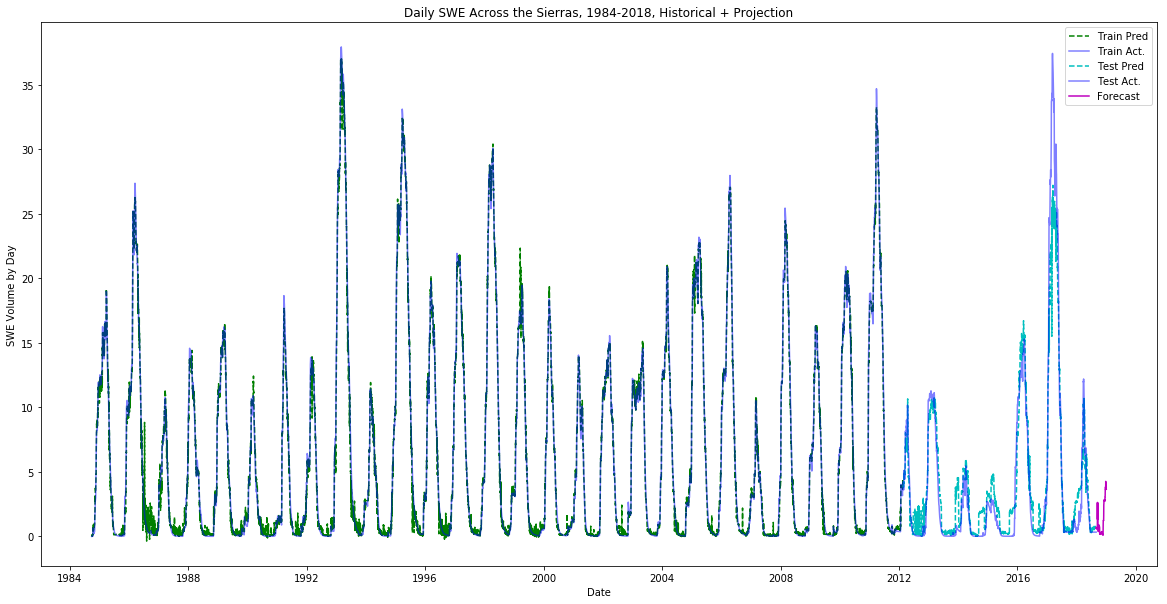

In [399]:
#quick plot to visualize data

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(train_graph[0],color='g',linestyle='--',label='Train Pred')
ax.plot(Y_train['vol'],color='b',alpha=0.5,label='Train Act.')

ax.plot(test_graph[0],color='c',linestyle='--',label='Test Pred')
ax.plot(Y_test['vol'],color='b',alpha=0.5,label='Test Act.')

ax.plot(pred_graph[0],color='m',label='Forecast')

ax.set_xlabel("Date")
ax.set_ylabel("SWE Volume by Day")
ax.set_title("Daily SWE Across the Sierras, 1984-2018, Historical + Projection")
plt.legend()

Text(0.5, 1.0, 'Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Train set)')

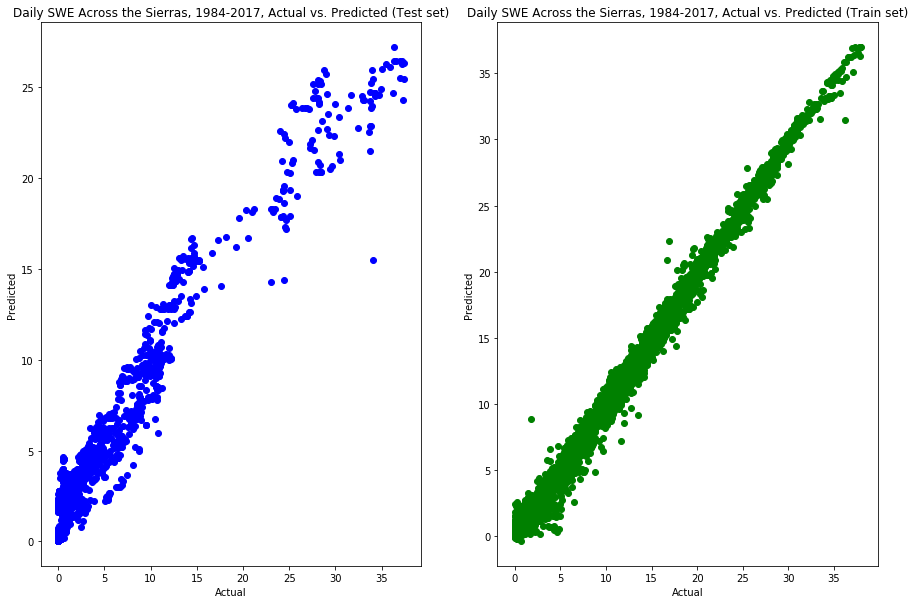

In [400]:
#scatter plot to show comparison of predicted vs actual on the training and test data sets

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)

ax.scatter(Y_test['vol'],test_graph[0],color='b')

ax1 = fig.add_subplot(122)

ax1.scatter(Y_train['vol'],train_graph[0],color='g')

ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title("Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Test set)")

ax1.set_xlabel("Actual")
ax1.set_ylabel("Predicted")
ax1.set_title("Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Train set)")

In [401]:
Y_test = pd.DataFrame(Y_test) #convert to df for correlation calc

In [402]:
Y_train = pd.DataFrame(Y_train) #convert to df for correlation calc

In [403]:
print("Test correlation: {}".format(Y_test['vol'].corr(test_graph[0])))
print("Train correlation: {}".format(Y_train['vol'].corr(train_graph[0])))


Test correlation: 0.9709764896070736
Train correlation: 0.9978003222041288


# Long Short Term Memory (LSTM RNN)

## Multi-variate LSTM

In [404]:
#scale values
scaler = MinMaxScaler(feature_range=(0,1)) #initialize scaler function
swe_scaled = scaler.fit_transform(swe.values) #fit-transform data set

In [405]:
swe_scaled.shape

(12501, 137)

In [406]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [407]:
lstm_data = series_to_supervised(swe_scaled,1,1)

In [408]:
lstm_data.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var128(t),var129(t),var130(t),var131(t),var132(t),var133(t),var134(t),var135(t),var136(t),var137(t)
1,0.000002,0.110426,0.882708,0.999347,0.294960,0.206204,0.922793,0.503236,0.189272,0.207201,...,0.812211,0.205839,0.925118,0.096354,0.640880,0.99711,0.383249,0.061577,0.929923,0.051306
2,0.000027,0.110427,0.882770,0.999347,0.295053,0.206243,0.922858,0.503368,0.189292,0.207208,...,0.812183,0.205812,0.925118,0.096336,0.640876,0.99711,0.383249,0.061576,0.929923,0.051306
3,0.000029,0.110428,0.882761,0.999347,0.295035,0.206234,0.922848,0.503348,0.189288,0.207207,...,0.812175,0.205805,0.925118,0.096328,0.640874,0.99711,0.383249,0.061576,0.929923,0.051306
4,0.000018,0.110428,0.882756,0.999347,0.295030,0.206233,0.922843,0.503339,0.189287,0.207206,...,0.812178,0.205808,0.925118,0.096329,0.640874,0.99711,0.383249,0.061576,0.929923,0.051306
5,0.000011,0.110427,0.882757,0.999347,0.295032,0.206234,0.922844,0.503340,0.189287,0.207206,...,0.812175,0.205805,0.925118,0.096327,0.640874,0.99711,0.383249,0.061576,0.929923,0.051306


In [409]:
lstm_data = lstm_data.iloc[:,:138]

In [410]:
lstm_data.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var129(t-1),var130(t-1),var131(t-1),var132(t-1),var133(t-1),var134(t-1),var135(t-1),var136(t-1),var137(t-1),var1(t)
1,0.000002,0.110426,0.882708,0.999347,0.294960,0.206204,0.922793,0.503236,0.189272,0.207201,...,0.205698,0.925117,0.096238,0.640853,0.997108,0.383249,0.061575,0.929923,0.051306,0.000027
2,0.000027,0.110427,0.882770,0.999347,0.295053,0.206243,0.922858,0.503368,0.189292,0.207208,...,0.205839,0.925118,0.096354,0.640880,0.997110,0.383249,0.061577,0.929923,0.051306,0.000029
3,0.000029,0.110428,0.882761,0.999347,0.295035,0.206234,0.922848,0.503348,0.189288,0.207207,...,0.205812,0.925118,0.096336,0.640876,0.997110,0.383249,0.061576,0.929923,0.051306,0.000018
4,0.000018,0.110428,0.882756,0.999347,0.295030,0.206233,0.922843,0.503339,0.189287,0.207206,...,0.205805,0.925118,0.096328,0.640874,0.997110,0.383249,0.061576,0.929923,0.051306,0.000011
5,0.000011,0.110427,0.882757,0.999347,0.295032,0.206234,0.922844,0.503340,0.189287,0.207206,...,0.205808,0.925118,0.096329,0.640874,0.997110,0.383249,0.061576,0.929923,0.051306,0.000006


In [412]:
lstm_data.shape

(12327, 138)

In [546]:
# split into train and test sets
values = lstm_data.values
test_size = 9000
train = values[:test_size, :]
test = values[test_size:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [547]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(9000, 1, 137) (9000,) (3327, 1, 137) (3327,)


In [548]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 9000 samples, validate on 3327 samples
Epoch 1/50
 - 4s - loss: 0.0423 - val_loss: 0.0382
Epoch 2/50
 - 1s - loss: 0.0352 - val_loss: 0.0284
Epoch 3/50
 - 1s - loss: 0.0255 - val_loss: 0.0193
Epoch 4/50
 - 1s - loss: 0.0106 - val_loss: 0.0013
Epoch 5/50
 - 1s - loss: 8.4559e-04 - val_loss: 7.7937e-05
Epoch 6/50
 - 1s - loss: 2.2274e-04 - val_loss: 9.7976e-05
Epoch 7/50
 - 1s - loss: 2.2932e-04 - val_loss: 1.1606e-04
Epoch 8/50
 - 1s - loss: 2.2824e-04 - val_loss: 9.2272e-05
Epoch 9/50
 - 1s - loss: 2.1940e-04 - val_loss: 7.6138e-05
Epoch 10/50
 - 1s - loss: 2.1714e-04 - val_loss: 7.5643e-05
Epoch 11/50
 - 1s - loss: 2.0508e-04 - val_loss: 7.3041e-05
Epoch 12/50
 - 1s - loss: 1.8853e-04 - val_loss: 7.2034e-05
Epoch 13/50
 - 1s - loss: 1.7812e-04 - val_loss: 7.4221e-05
Epoch 14/50
 - 1s - loss: 1.6733e-04 - val_loss: 7.2476e-05
Epoch 15/50
 - 1s - loss: 1.6736e-04 - val_loss: 7.0154e-05
Epoch 16/50
 - 1s - loss: 1.8149e-04 - val_loss: 7.1664e-05
Epoch 17/50
 - 1s - loss: 2.0508e

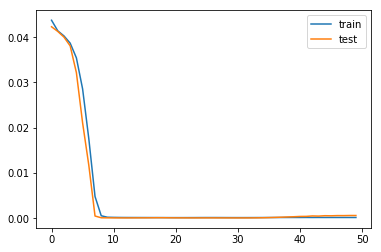

In [416]:
# plot rmse by epoch
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Note: probably just need 20-30 epochs

In [417]:
# make a prediction and prepare data for graphing 

#test data transformation
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


#train data transformation
yhat_t = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# invert scaling for forecast
inv_yhat_t = concatenate((yhat_t, train_X[:, 1:]), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,0]
# calculate RMSE
rmse_t = sqrt(mean_squared_error(inv_y_t, inv_yhat_t))
print('Train RMSE: %.3f' % rmse_t)

Test RMSE: 0.942
Train RMSE: 0.939


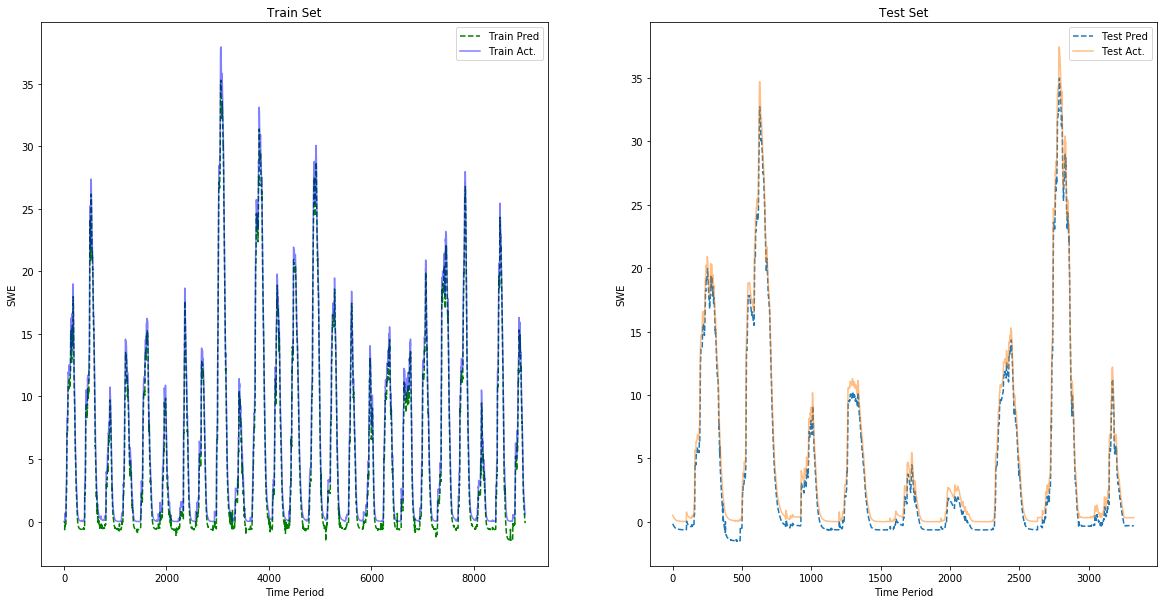

In [418]:
#graph train and test

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(122)

ax.plot(inv_yhat,linestyle='--',label='Test Pred')
ax.plot(inv_y,alpha=0.5,label='Test Act.')

ax1 = fig.add_subplot(121)

ax1.plot(inv_yhat_t,color='g',linestyle='--',label='Train Pred')
ax1.plot(inv_y_t,color='b',alpha=0.5,label='Train Act.')

ax.set_title("Test Set")
ax.set_xlabel("Time Period")
ax.set_ylabel("SWE")

ax1.set_title("Train Set")
ax1.set_xlabel("Time Period")
ax1.set_ylabel("SWE")

ax1.legend()
ax.legend()

Text(0.5, 1.0, 'Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Train set)')

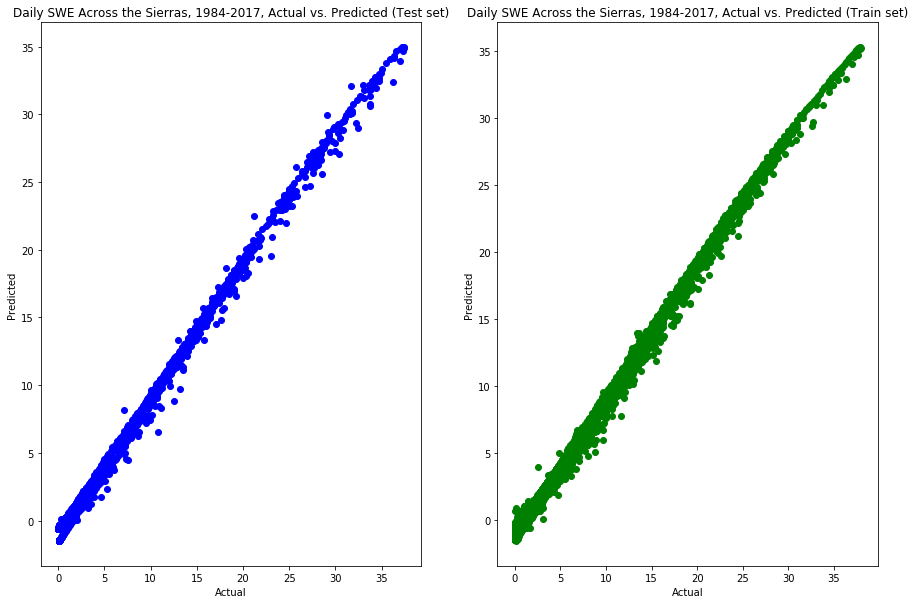

In [419]:
#scatter plot to show comparison of predicted vs actual on the training and test data sets

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)

ax.scatter(inv_y,inv_yhat,color='b')

ax1 = fig.add_subplot(122)

ax1.scatter(inv_y_t,inv_yhat_t,color='g')

ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title("Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Test set)")

ax1.set_xlabel("Actual")
ax1.set_ylabel("Predicted")
ax1.set_title("Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Train set)")

In [420]:
print("test correlation: {}".format(pearsonr(inv_y,inv_yhat)))
print("train correlation: {}".format(pearsonr(inv_y_t,inv_yhat_t)))

test correlation: (0.9989921869563648, 0.0)
train correlation: (0.9991531209153617, 0.0)


## Adjusting Window size and tweaking other hyper parameters to improve RMSE

comments: starting with the baseline model from the previous run and testing hyper parameters in the following order (while holding other variables constant):

window size

epochs

batch size

number of neurons

In [655]:
#set random seeds for tuning for comparative purposes
from tensorflow import set_random_seed
set_random_seed(2)

from numpy.random import seed
seed(2)

In [724]:
#set lag periods and 
window_size = 7
n_features = 137

# frame as supervised learning
reframed = series_to_supervised(swe_scaled, window_size, 1)

In [725]:
reframed.shape

(12177, 1096)

In [726]:
# split into train and test sets
values = reframed.values
test_size = 9000
train = values[:test_size, :]
test = values[test_size:, :]

In [727]:
# split into input and outputs
n_obs = window_size * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(9000, 959) 9000 (9000,)


In [728]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window_size, n_features))
test_X = test_X.reshape((test_X.shape[0], window_size, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(9000, 7, 137) (9000,) (3177, 7, 137) (3177,)


In [729]:
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 9000 samples, validate on 3177 samples
Epoch 1/100
 - 8s - loss: 0.0543 - val_loss: 0.0371
Epoch 2/100
 - 3s - loss: 0.0394 - val_loss: 0.0295
Epoch 3/100
 - 3s - loss: 0.0334 - val_loss: 0.0183
Epoch 4/100
 - 3s - loss: 0.0203 - val_loss: 0.0071
Epoch 5/100
 - 3s - loss: 0.0035 - val_loss: 4.8263e-04
Epoch 6/100
 - 3s - loss: 0.0011 - val_loss: 3.5680e-04
Epoch 7/100
 - 3s - loss: 0.0021 - val_loss: 4.1415e-04
Epoch 8/100
 - 3s - loss: 0.0011 - val_loss: 4.0199e-04
Epoch 9/100
 - 3s - loss: 0.0020 - val_loss: 3.9824e-04
Epoch 10/100
 - 3s - loss: 0.0015 - val_loss: 3.0218e-04
Epoch 11/100
 - 3s - loss: 0.0014 - val_loss: 6.0248e-04
Epoch 12/100
 - 3s - loss: 0.0015 - val_loss: 7.6348e-04
Epoch 13/100
 - 3s - loss: 0.0013 - val_loss: 7.1482e-04
Epoch 14/100
 - 3s - loss: 0.0012 - val_loss: 8.2747e-04
Epoch 15/100
 - 3s - loss: 0.0012 - val_loss: 0.0011
Epoch 16/100
 - 3s - loss: 0.0011 - val_loss: 0.0012
Epoch 17/100
 - 3s - loss: 0.0011 - val_loss: 0.0016
Epoch 18/100
 - 3s -

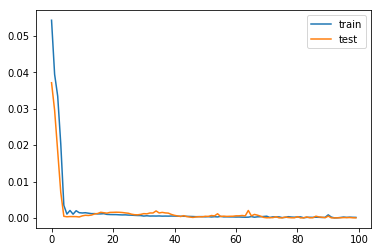

In [730]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [731]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], window_size*n_features))
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# invert scaling for forecast
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse1 = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: {}'.format(rmse1))

#train data transformation
yhat_t = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], window_size*n_features))
# invert scaling for forecast
inv_yhat_t = concatenate((yhat_t, train_X[:, -(n_features-1):]), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = concatenate((train_y, train_X[:, -(n_features-1):]), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,0]
# calculate RMSE
rmse_t = sqrt(mean_squared_error(inv_y_t, inv_yhat_t))
print('Test RMSE: {}'.format(rmse_t))

Test RMSE: 0.2870279812939994
Test RMSE: 0.251264641937342


Notes:

window_size tuning: 2 (rmse = 1.42), 3 (1.00), 4 (1.06), 5 (0.65), 6 (0.59), 7 (0.38), 8 (0.60).

Epoch tuning w/ window =7: 10 (rmse =  1.12), 20 (0.82), 40 (0.44), 50 (0.38), 70 (0.46), 100 (0.248). 

Batch_size tuning (w=7,epoch=100): 36 (0.308), 18 (0.66), 100 (0.54)

Neuron tuning (w=7,epoch=100,batch_size=36): 20 (0.34), 25 (rmse = 0.278)

tuned model: window_size = 7, epochs = 100, batch_size = 36, neurons =  25


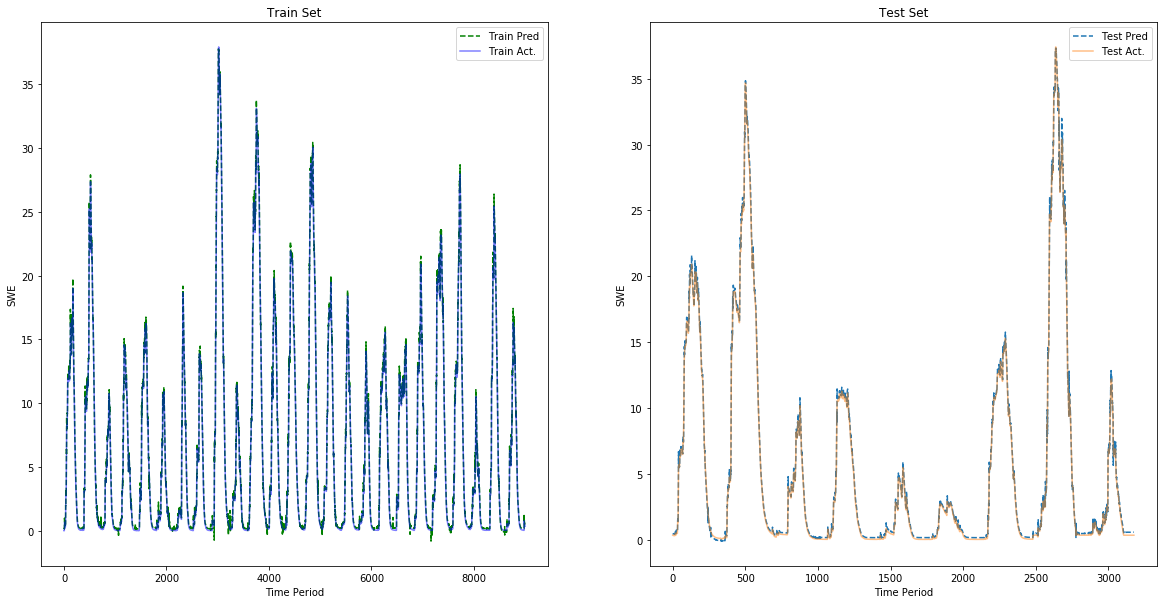

In [732]:
#graph train and test

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(122)

ax.plot(inv_yhat,linestyle='--',label='Test Pred')
ax.plot(inv_y,alpha=0.5,label='Test Act.')

ax1 = fig.add_subplot(121)

ax1.plot(inv_yhat_t,color='g',linestyle='--',label='Train Pred')
ax1.plot(inv_y_t,color='b',alpha=0.5,label='Train Act.')

ax.set_title("Test Set")
ax.set_xlabel("Time Period")
ax.set_ylabel("SWE")

ax1.set_title("Train Set")
ax1.set_xlabel("Time Period")
ax1.set_ylabel("SWE")

ax1.legend()
ax.legend()